# CRN Modeling with MobsPy

This lecture covers:

**Concepts**

- The MobsPy simulation framework
- Stochastic simulation of CRNs
- Deterministic simulation of CRNs

<hr>

## MobsPy

MobsPy is a Python-based language to specify, simulate, and analyze CRNs. It follows a modular, object-oriented, approach, where species are grouped into meta-species and reactions into meta-reactions. For an overview see [Cravo, Függer, Nowak, Prakash. CMSB](https://hal.science/hal-03876041). There is also detailed documentation available on [readthedocs.io](https://mobspy-doc.readthedocs.io/en/latest/).

While we have already used MobsPy in the Introduction lecture to simulate basic CRNs, this writeup discusses its features in greater detail.

The Python library is available via [pypi](https://pypi.org/project/mobspy/) and [github](https://github.com/ROBACON/mobspy).
You can install it by uncommenting and running:

In [20]:
# %pip install mobspy

Let's start by including some basic MobsPy classes and plotting.

In [21]:
from mobspy import BaseSpecies, Simulation, Zero, u, New
import matplotlib.pyplot as plt

The most basic concept is a `BaseSpecies`. They represent the species within a CRN. Let us start with a simple model of a genetic circuit that has as input a repressor and as output GFP.

Our species are:
- Repressor molecule
- DNA that contains the circuit: each one can be in a `free` and `occupied` (by the repressor) state.
- mRNA (of GFP sequence)
- GFP

In MobsPy species are automatically named according to the variable names and can be created with a single call.
For the moment, we do not specify states of these species.

In [22]:
Repressor, DNA, mRNA, GFP = BaseSpecies()

Following a classical CRN, we should have declared two species for `DNA`, one for it being `free` and one being `occupied`. While we could have written `Repressor, DNAfree, DNAoccupied, mRNA, GFP = BaseSpecies()`, MobsPy has a way to specify these states or characteristics of species which we are going to use. After creating a species one can simply create characteristics of it with:

In [23]:
DNA.free, DNA.occupied

(<mobspy.modules.meta_class.Reacting_Species at 0x114908c50>,
 <mobspy.modules.meta_class.Reacting_Species at 0x1149c4680>)

> **_Side note:_** We could have skipped the line since characteristics can be created 'on the fly', but for better readability it is good habit to make characteristics explicit for each species.

For all species with non-zero initial values, we need to specify the value. It is good practice to set the volume at this time too.
Since, we already know that DNA can be in two states and we want it to be all initially in the `free` state, we also specify the particular state (also called characteristics) for the initial value.

While MobsPy allows also unitless volumes, counts/concentrations, and rates, it is good practice to specify all with units.
The unit registry `u` that we imported is done for this. It behaves like a `pint` unit registry, but with some adaptations for MobsPy.

In [24]:
# volume of E. coli
volume = 1 * u.femtoliter

# Let us assume a design on a plasmid with copy number 10
# and all are in free initially
DNA.free(10 / volume)

Next let's describe the reactions and their rates.

Reactions are written as `A + ... >> B + ... [rate constant]`.

For the moment we will use only mass-action kinetics. For ODE semantics this is just the product of all reactant concentrations times a rate constant. This rate constant is specified within `[]`.

In [25]:
# repression
DNA.free + Repressor >> DNA.occupied [1.0  * volume / u.min]
DNA.occupied >> DNA.free + Repressor [1.0 / u.min]

# transcription
DNA.free >> DNA.free + mRNA [1.0 / u.min]

# translation
mRNA >> mRNA + GFP [1.0 / u.min]

# dilution + degradation
mRNA >> Zero [1 / (20 * u.min)]
GFP >> Zero [1 / (20 * u.min)]

Once we are done specifying the CRN, we create a `Simulation` object with all all the species that are to be simulated specified, separated by the `|` operator to indicate parallel composition.

Compiling model
Starting Simulator
Simulation is Over


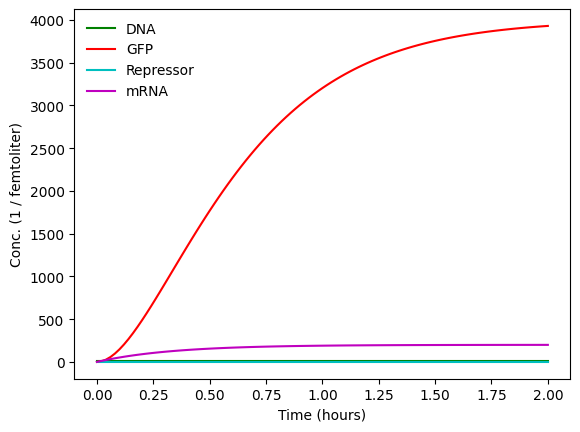

In [26]:
Sim = Simulation(DNA | mRNA | Repressor | GFP)
Sim.volume = volume
Sim.unit_y=1 / volume
Sim.run(duration= 2 * u.hour, unit_y=1 / volume, simulation_method="deterministic")

For comparison, we can easily run a stochastic simulation, too.

Starting Simulator
Simulation is Over


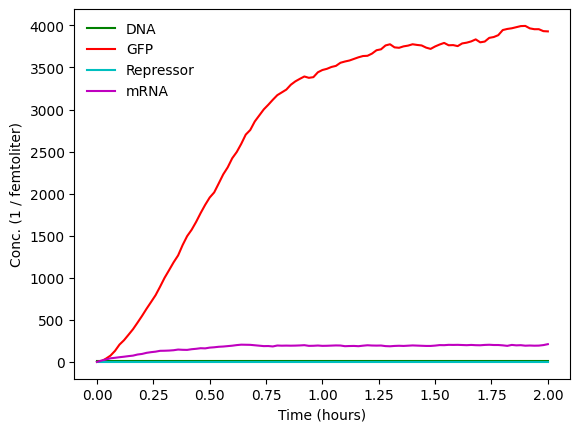

In [27]:
Sim.run(duration= 2 * u.hour, unit_y=1 / volume, simulation_method="stochastic")

Or multiple ones to observer variations. Remember though from the lecture that these variations are due to the thermodynamics. They do not model noise due to plasmid copy number changes, competing processes, environmental variations, etc.

Starting Simulator
Simulation is Over


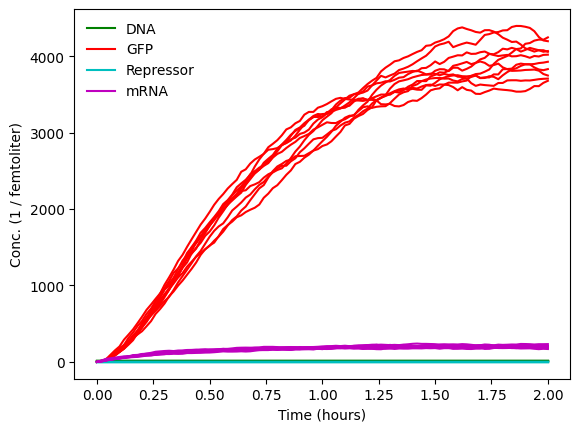

In [28]:
Sim.run(duration= 2 * u.hour, unit_y=1 / volume, simulation_method="stochastic", repetitions=10)

Most of the time, we would like to do something with the simulation data. To get the results, in this case the first 4 values from repetition 0, we can access them via:

In [29]:
Sim.results["Time"][0][:4], Sim.results["DNA.free"][0][:4]

([0.0, 0.02, 0.04, 0.06], [10.0, 10.0, 10.0, 10.0])

For example, plotting `DNA.free` over time in a log plot is done by:

Text(0, 0.5, 'GFP (1/vol)')

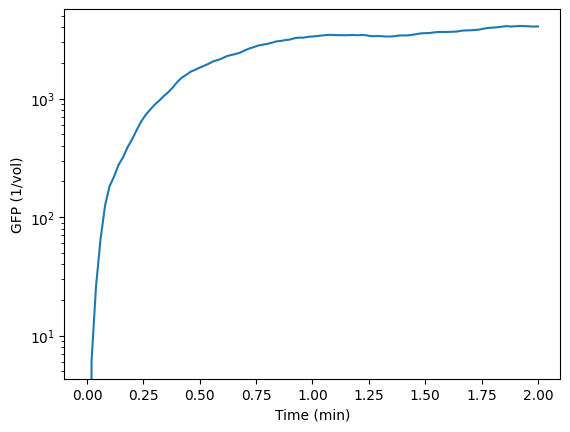

In [30]:
plt.plot(Sim.results["Time"][0], Sim.results["GFP"][0])
plt.gca().set_yscale('log')
plt.xlabel("Time (min)")
plt.ylabel("GFP (1/vol)")

Whenever you plan to sweep through models and change species, reactions, etc. It is good practice to encapsulate the model in a function.

In [31]:
def repressor_model(repressor_cnt: int = 0, dna_cnt: int = 10) -> Simulation:
    Repressor, DNA, mRNA, GFP = BaseSpecies()
    DNA.free, DNA.occupied

    # volume of E. coli
    volume = 1 * u.femtoliter

    DNA.free(dna_cnt / volume)
    Repressor(repressor_cnt / volume)

    # repression
    DNA.free + Repressor >> DNA.occupied [1.0 * volume / u.min]
    DNA.occupied >> DNA.free + Repressor [1.0 / u.min]

    # transcription
    DNA.free >> DNA.free + mRNA [1.0 / u.min]

    # translation
    mRNA >> mRNA + GFP [1.0 / u.min]

    # dilution + degradation
    mRNA >> Zero [1 / (20 * u.min)]
    GFP >> Zero [1 / (20 * u.min)]

    Sim = Simulation(DNA | mRNA | Repressor | GFP)
    Sim.volume = volume
    Sim.unit_y=1 / volume

    return Sim

Compiling model
Starting Simulator
Simulation is Over


Text(0, 0.5, 'Occupied DNA (1/vol)')

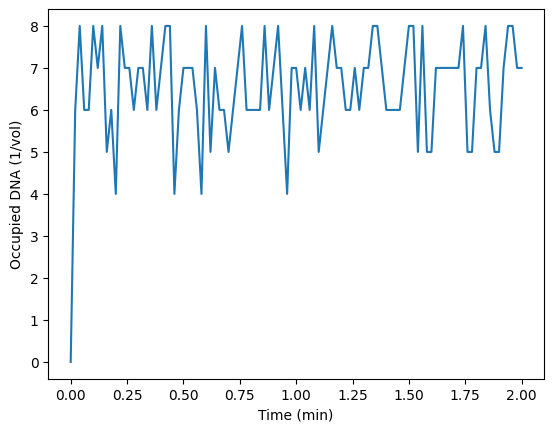

In [32]:
model = repressor_model(10)
model.run(duration= 2 * u.hour, unit_y=1 / volume, simulation_method="stochastic", plot_data=False)

plt.plot(model.results["Time"][0], model.results["DNA.occupied"][0])
plt.xlabel("Time (min)")
plt.ylabel("Occupied DNA (1/vol)")

We are now in the position to plot the input-output characteristic of this repressor.

Text(0, 0.5, 'GFP (1/vol)')

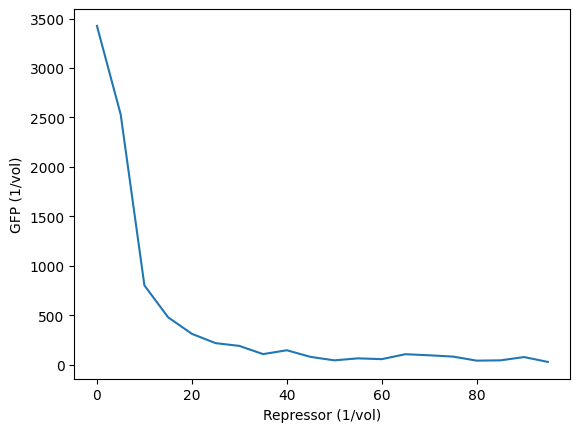

In [33]:
x: list[float] = []
y: list[float] = []
for repressor_cnt in range(0, 100, 5):
    model = repressor_model(repressor_cnt)
    duration = 2 * u.hour  # NOTE: check to make sure this is really the steady state
    model.run(duration=duration, unit_y=1 / volume, simulation_method="stochastic", plot_data=False, level= 0)
    x.append(repressor_cnt)
    y.append(model.results["GFP"][0][-1])  # NOTE: this only uses 1 stochastic run

plt.plot(x, y)
plt.xlabel('Repressor (1/vol)')
plt.ylabel('GFP (1/vol)')

## Species that share Reactions

Sometimes it is convenient to specify reactions on (abstract or meta) species and then derive the concrete species from them.

For example, we could specify dilution and degradation via:

In [34]:
Degrading = BaseSpecies()
Degrading >> Zero [1.0 / (20 * u.min)]

mRNA, GFP = New(Degrading)

## Reaction Rates

Until now we have only used mass-action kinetics and did this by providing a number, the rate constant. Sometimes one needs to deviate from these and
1. Let this number be computed by a function.
2. Specify the rate function instead of using mass-action kinetics.


### Reaction rate constants as functions

To demonstrate the 1st point let us assume that we want to model different degradation rates for mRNA and GFP. We can do this by:

In [35]:
def degradation_rate_constant(d):
    if d.is_a(mRNA):
        return 1.0 / (20 * u.min)
    elif d.is_a(GFP):
        return 2.0 / (20 * u.min)
    else:
        raise NotImplementedError(f"do not know how to degrade '{d}'")

Degrading = BaseSpecies()
Degrading >> Zero [degradation_rate_constant]

mRNA, GFP = New(Degrading)

Let's test it at a simple example of just degrading the two.

Compiling model
Starting Simulator
Simulation is Over


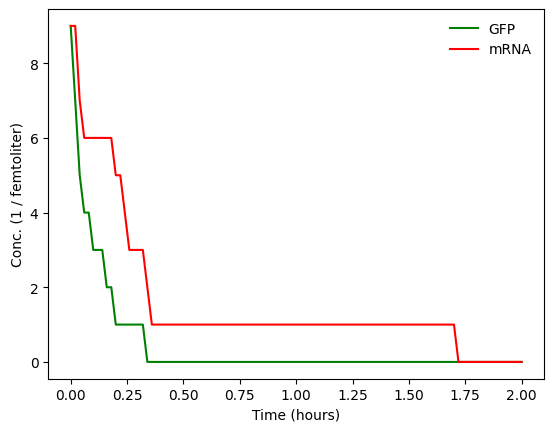

In [36]:
mRNA(10 / volume)
GFP(10 / volume)

Sim = Simulation(mRNA | GFP)
Sim.volume = volume

Sim.run(duration= 2 * u.hour, unit_y=1 / volume, simulation_method="stochastic")

### Beyond mass-action kinetics

To specify not only reaction rate constants, but the complete reaction rate as a function of the reactant concentrations you can either:
- Use the species in the returned value.
- Return an expression as a `str`. This is practical if you want to return a constant rate that is not a reaction rate constant.

For example, instead of the reaction rate $\gamma \time Degrading$ we want to specify a rate $\gamma \time (Degrading - 1)$. This will be $0$, and thus stop degrading, at $Degrading = 1$.

We can do this by:

Compiling model
Starting Simulator
Simulation is Over


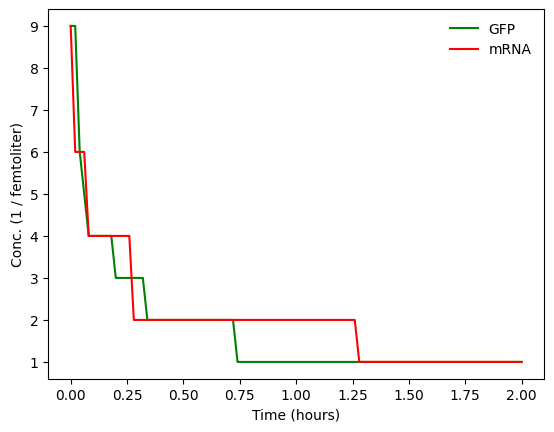

In [37]:
def degradation_rate_constant(d):
    if d.is_a(mRNA):
        return 1.0 / (20 * u.min) * (d-1)
    elif d.is_a(GFP):
        return 2.0 / (20 * u.min) * (d-1)
    else:
        raise NotImplementedError(f"do not know how to degrade '{d}'")

Degrading = BaseSpecies()
Degrading >> Zero [degradation_rate_constant]

mRNA, GFP = New(Degrading)

mRNA(10 / volume)
GFP(10 / volume)

Sim = Simulation(mRNA | GFP)
Sim.volume = volume

Sim.run(duration= 2 * u.hour, unit_y=1 / volume, simulation_method="stochastic")

The following is a quick overview on reaction rate constant vs reaction rate semantics. Uncomment to see the differences.

Compiling model
Starting Simulator
Simulation is Over


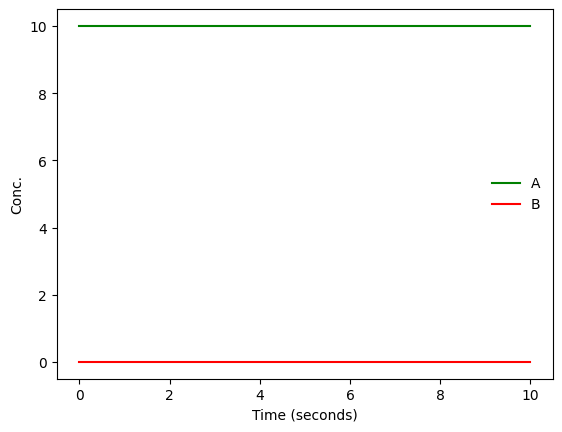

In [38]:
A, B = BaseSpecies()
A(10)

# All these are mass-action kinetics:
# A >> B [1.0]
# A >> B [1.0 / u.s]  # just with units
# A >> B [lambda a: 1.0 / u.s]  # careful, still as rate constant

# All these are rate functions:
# A >> B [lambda a: 1.0 / u.s * a]  # as before
# A >> B [lambda a: 1.0 / u.s + 0 * a]  # different, kind of force as rate
# A >> B [lambda a: str(1.0 / u.s)]  # different, force a number as rate

# run
S = Simulation(A | B)
S.duration = 10 * u.s
S.run()

---
**License**: © 2025 Matthias Függer and Thomas Nowak. Licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).